In [1]:
data_dir = '/Users/bharathg/workspace/mscs/csca5642/week3'
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import tensorflow as tf
import os
from pathlib import Path

# Description

The challenge is to build CNN models to identify whether there are cancer cells in small image patches taken from larger pathology scans. The images in the dataset are 96x96 pixels in size with 3 color channels and are taken from the PCam dataset. The dataset is from the kaggle competition https://www.kaggle.com/competitions/histopathologic-cancer-detection and the task is to identify whether there is atleast one pixel of tumor tissue in the center 32x32 pixels of the image.

There are 220,025 training images and 57,458 test images. The training images are labeled as 0 or 1, where 0 indicates no tumor pixels and 1 indicates atleast one tumor pixel. The test images are unlabeled.




# Exploratory Data Analysis (EDA)


In [2]:
# Read the training labels
training_labels = utils.load_training_labels(data_dir)
print(training_labels.shape)
print(training_labels.head())
print(training_labels['label'].value_counts())


(220025, 2)
                                         id  label
0  752b40e8a3305f492bb9797bd9d0bb22ff144df4  False
1  5c013b0c605b647f5df940d3dc4f6aa72ce7a473  False
2  db26b4d07c07e926068d5dd944ae0716e0d78484   True
3  904fd6192430e655760b1676050af3db7c01ef39  False
4  e141bcfc5187a4d23d0343f99e01c61d8119d93e   True
label
False    130908
True      89117
Name: count, dtype: int64


From the above output, we can see that the training data has 130908 images without tumor tissue and 89117 images with tumor tissue. The dataset is slightly imbalanced.


Visualizing a few sample images from the training dataset. 

2025-04-08 15:17:04.417750: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-08 15:17:04.417781: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-08 15:17:04.417788: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1744105624.417801  878409 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744105624.417826  878409 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


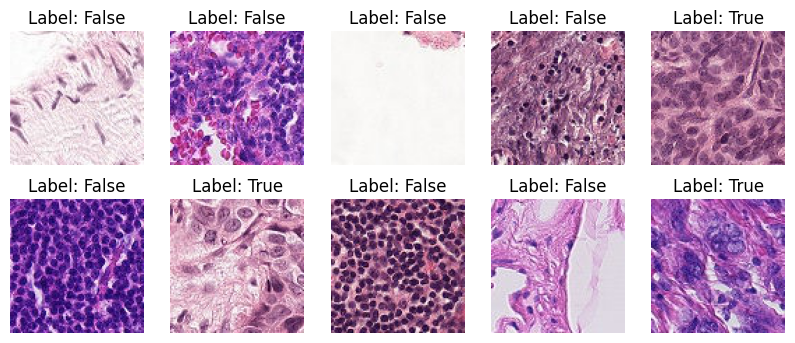

In [3]:
sample_training_labels = training_labels.sample(10)
sample_images = utils.get_training_images(sample_training_labels, data_dir)
sample_labels = sample_training_labels['label']

plt.figure(figsize=(10, 4))
for image, label, i in zip(sample_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Since the problem is to look at tumor tissues in the center 32x32 pixels of the image, let's crop and visualize the center of the images

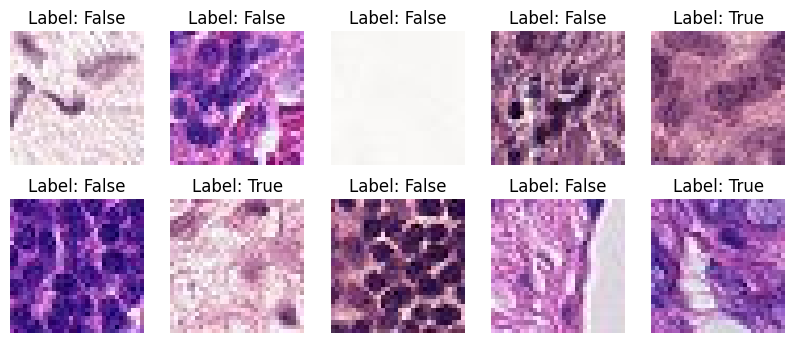

In [4]:
cropped_images = [tf.image.central_crop(image, 1/3).numpy() for image in sample_images]
plt.figure(figsize=(10, 4))
for image, label, i in zip(cropped_images, sample_labels, range(len(cropped_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Also looking at a few images in greyscaleale both the full images and the cropped 32x32 center patches.

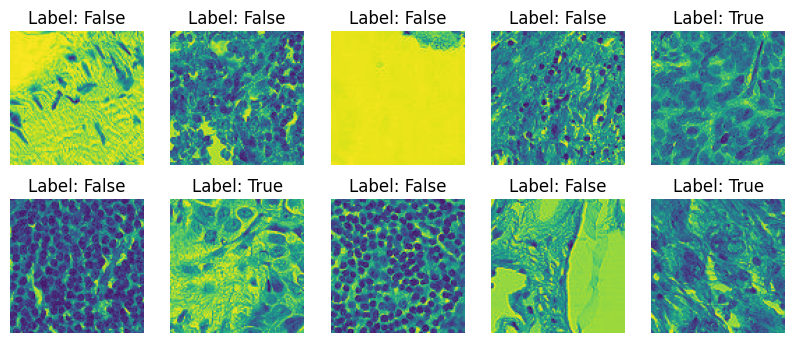

In [5]:
sample_images = utils.get_training_images(sample_training_labels, data_dir, color_mode='grayscale')
sample_labels = sample_training_labels['label']
plt.figure(figsize=(10, 4))
for image, label, i in zip(sample_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()




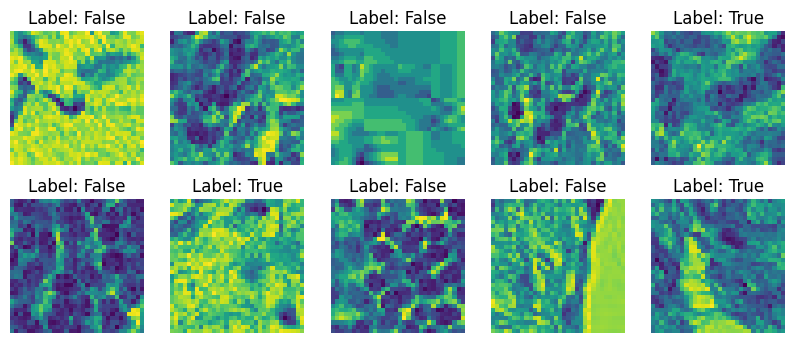

In [6]:
cropped_images = [tf.image.central_crop(image, 1/3).numpy() for image in sample_images]

plt.figure(figsize=(10, 4))
for image, label, i in zip(cropped_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

The plan is to train CNN based models on the 32x32 center patches with color information and also on just the grayscale images. We will compare the results of the two 
models to see whether color information is useful for this task.

I also plan to try a few different model architectures to see which one performs the best. And also try to see how the models scale with the number of training samples used.

I also plan to see if using the full 96x96 patches makes any difference to the results.

### TODO
Add more visualizations and data analysis

# Model building and tuning

I will start with a simple CNN based model with one fully connected layer at the end for classification. I will use all the training images and use a fraction of them as validation set. I will just use the 32x32 center patches to start with color information.

In [7]:
# Prepare the training data
X = utils.get_training_images(training_labels, data_dir, crop=True)
y = training_labels['label'].values

print(X.shape)
print(y.shape)


(220025, 32, 32, 3)
(220025,)


I will use a few groups with 2 convolution layers and a pooling layer followed by a single fully connected hidden layer for classification. 
The convolution layers will do the feature extraction and then the final FC hidden layer will do the classification.
I will use sigmoid for the output layer since this is a binary classification problem and ReLU activation for all the other layers.
I will also rescale the image data from 0-255 to 0-1 and apply BatchNormalization at the end of each convolution group and after the FC hidden layer.

In [3]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 3)),
    keras.layers.Rescaling(1./255),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
model.summary()

/Users/bharathg/.virtualenvs/deep_learning/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-04-08 16:03:42.013398: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-08 16:03:42.013638: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-08 16:03:42.013649: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1744108422.014114  944059 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744108422.014634  944059 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,177 (1.99 MB)

 Trainable params: 520,961 (1.99 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/40


2025-04-08 15:29:39.013444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.8441 - accuracy: 0.7817 - loss: 0.4895
Epoch 1: val_AUC improved from -inf to 0.86865, saving model to model.cnn1.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 62s 44ms/step - AUC: 0.8441 - accuracy: 0.7817 - loss: 0.4894 - val_AUC: 0.8686 - val_accuracy: 0.7866 - val_loss: 0.4572
Epoch 2/40
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.8887 - accuracy: 0.8203 - loss: 0.4078
Epoch 2: val_AUC did not improve from 0.86865
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 52s 40ms/step - AUC: 0.8887 - accuracy: 0.8203 - loss: 0.4078 - val_AUC: 0.8532 - val_accuracy: 0.7738 - val_loss: 0.4929
Epoch 3/40
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.9068 - accuracy: 0.8379 - loss: 0.3748
Epoch 3: val_AUC improved from 0.86865 to 0.88672, saving model to model.cnn1.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - AUC: 0.9068 - accuracy: 0.8379 - loss: 0.3748 - val_AUC: 0.8867 - val_accuracy: 0.7813 - val_loss: 0.4987
Epoch 4/40
1290/1290 ━━━━━━━━━━━

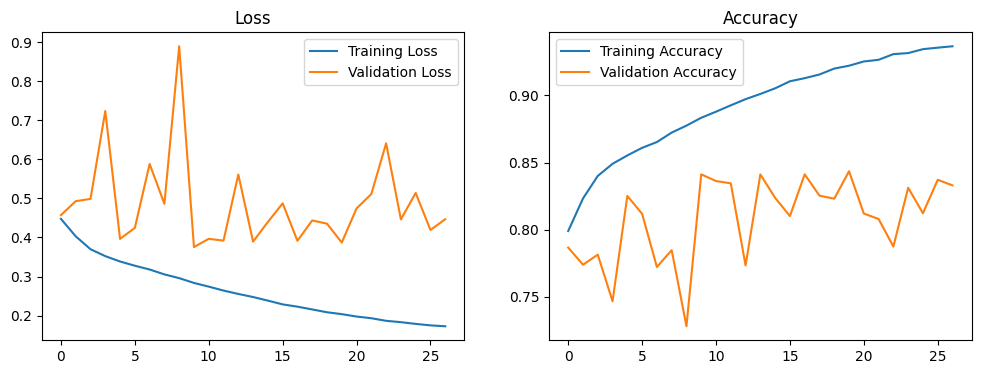

In [11]:
checkpointer = keras.callbacks.ModelCheckpoint(
    'model.cnn1.keras', 
    save_best_only=True,
    verbose=1,
    monitor='val_AUC',
    mode='max')
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    verbose=1,
    monitor='val_AUC',
    mode='max')

history = model.fit(X, y, epochs=40, batch_size=128, validation_split=0.25, callbacks=[checkpointer, early_stopping])
# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


In [4]:
def get_test_images(data_dir='./', color_mode='rgb', crop=False):
    test_image_files = [f for f in os.listdir(os.path.join(data_dir, "test")) if f.endswith(".tif")]
    test_ids = [Path(f).stem for f in test_image_files]
    test_images = np.array(
        [tf.image.central_crop(
            keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'test', f), color_mode=color_mode)),
            1/3 if crop else 1).numpy()
         for f in test_image_files])
    return test_images, test_ids


def generate_submission(model, test_images, test_ids, color_mode='rgb', output_file='submission.csv'):
    test_predictions = model.predict(test_images)
    submission_probs = pd.DataFrame({"id": test_ids, "label": test_predictions.flatten()})
    binary_predictions = (test_predictions > 0.5).astype("int32")
    submission_binary = pd.DataFrame({"id": test_ids, "label": binary_predictions.flatten()})
    submission_probs.to_csv(output_file, index=False)
    submission_binary.to_csv(output_file.replace('.csv', '_binary.csv'), index=False)

In [5]:
model.load_weights('model.cnn1.keras')
test_images, test_ids = get_test_images(data_dir, crop=True)
print(test_images.shape)
generate_submission(model, test_images, test_ids, output_file='submission.csv')

/Users/bharathg/.virtualenvs/deep_learning/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


(57458, 32, 32, 3)


2025-04-08 16:05:34.810894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


# Results and Analysis

# Conclusion